In [8]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *

### Define and solve the eigenproblem

In [199]:
N_states = 5

ν_ge = 6.0  # atom frequency, GHz
Ec = 0.2
Ej = (ν_ge-Ec)**2/Ec/8 # see Koch's paper for the approximation of the ge transition frequency

def n():
    return num(2*N_states+1, offset = -N_states)
def Hc():
    return 4*Ec*n()**2
def Hj():
    return 0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))
def H_undr():
    return Hj()+Hc()

In [200]:
def solve_eigenproblem():
    return H_undr().eigenstates()

In [201]:
evals, evecs = solve_eigenproblem()
real_evecs = [np.real(evec.data.toarray()) for evec in evecs]

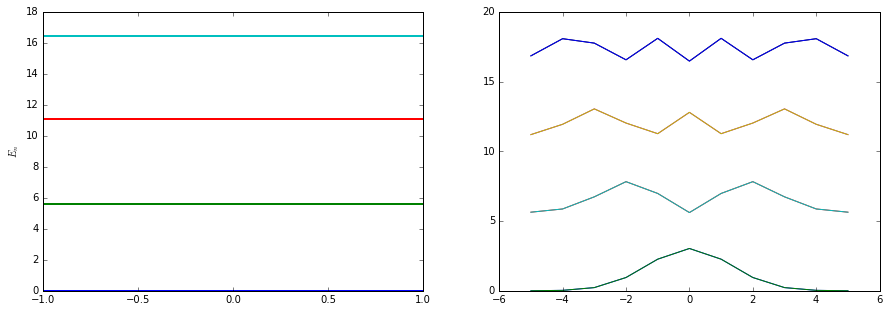

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].set_ylabel(r'$E_n$')
for i in range(0,4):
    axes[0].plot([-1,1], evals[i] * np.ones(2)-evals[0], linewidth=2)
    axes[1].plot(range(-N_states, N_states+1), abs(real_evecs[i])**2*10+evals[i] * np.ones(2)-evals[0], '-')

### Solve the dynamics

In [203]:
def c():
    return sum([n().matrix_element(evecs[j], evecs[j+1])/n().matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

In [204]:
Hf = 0.05 * n()
Hf_coeff_cython = "sin(t * w + phi)"
Args = {'w' : evals[1]-evals[0], 'phi' : 0}

psi0 = evecs[0]
tlist = np.linspace(0,200,400)

In [205]:
c_op_list = []

# gamma_dephase = 0.00
gamma_m = 0.01
c_op_list.append(np.sqrt(gamma_m) * c())

# rate = gamma_dephase/2     не знаю что тут должно быть, но точно не num_pm, он тут неправильно стоял
# if rate > 0.0:
#     c_op_list.append(np.sqrt(rate) * num_pm(N_states))

In [206]:
H = [H_undr(), [Hf, Hf_coeff_cython]]
expected = [H_undr()]
for i in range(len(evecs)):
    expected.append(evecs[i]*evecs[i].dag())
output = mesolve(H, psi0, tlist, c_op_list, expected, args = Args,options= Options(nsteps=10000), progress_bar=True)

10.0%. Run time:   0.28s. Est. time left: 00:00:00:02
20.0%. Run time:   0.59s. Est. time left: 00:00:00:02
30.0%. Run time:   0.93s. Est. time left: 00:00:00:02
40.0%. Run time:   1.37s. Est. time left: 00:00:00:02
50.0%. Run time:   1.94s. Est. time left: 00:00:00:01
60.0%. Run time:   2.42s. Est. time left: 00:00:00:01
70.0%. Run time:   2.90s. Est. time left: 00:00:00:01
80.0%. Run time:   3.35s. Est. time left: 00:00:00:00
90.0%. Run time:   3.78s. Est. time left: 00:00:00:00
Total run time:   4.21s


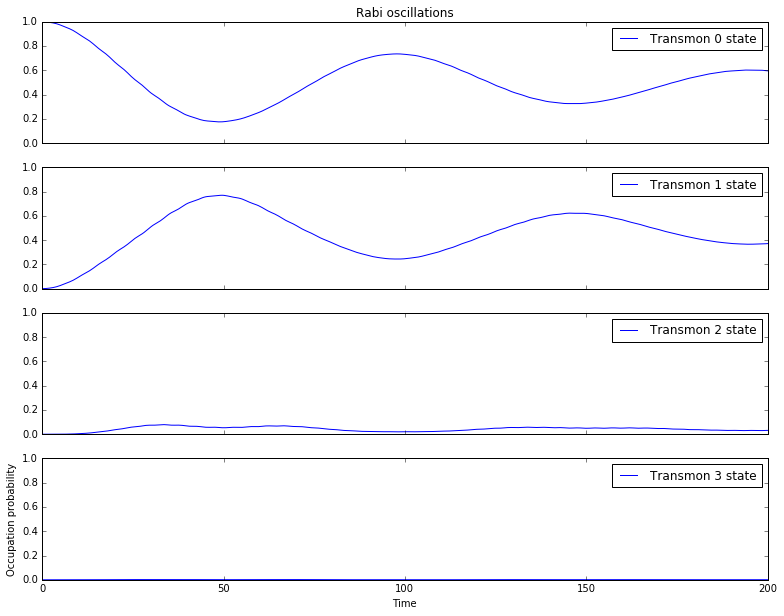

In [218]:
fig, axes = plt.subplots(4,1, figsize=(13,10), sharex=True)
axes[0].set_title('Rabi oscillations');
for idx, ax in enumerate(axes):
    ax.plot(tlist, output.expect[1+idx], label="Transmon %i state"%idx)
    ax.set_ylim(0,1)
    ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')